In [1]:
import os
import pandas as pd
import numpy as np
import copy
import warnings


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import matplotlib.pyplot as plt

path = os.getcwd()
raw_df = pd.read_csv(os.path.join(path,'2022_raw.csv')).tail(-1)


In [3]:
# Recode some responses including Likert scales
coded_df = copy.deepcopy(raw_df)
coded_df['Demo_main_3_mc'] = coded_df['Demo_main_3_mc'].replace('Number', 'Physical')
coded_df['Demo_main_3_mc'] = coded_df['Demo_main_3_mc'].replace('NA - Virtual Only', 'Virtual')

sales_profit_mapping = {'15%+ Decrease': -4, '10-14% Decrease': -3, '5-9% Decrease': -2,
                        '0-4% Decrease': -1, 'Neither Up nor Down': 0, '0-4% Increase': 1,
                        '5-9% Increase': 2, '10-14% Increase': 3, '15%+ Increase': 4}
coded_df = coded_df.assign(Recoded_Sales=coded_df['Bhea_Sales_3_list'].map(sales_profit_mapping))

revenue_mapping = {'Less than $99k': 1, '$100k - $199K': 2, '$200k - $299k': 3,
                   '$300k - $399k': 4, '$400k - $499k': 5, '$500k - $699k': 6,
                   '$700k - $1M': 7, '$1M - $1.49M': 8, '$1.5M - $1.9M': 9,
                   '$2M - $2.9M': 10, '$3M - $5.0M': 11, 'Greater than $5.0M': 12}
coded_df = coded_df.assign(Recoded_Revenue=coded_df['Demo_main_6_list'].map(revenue_mapping))

coded_df = coded_df.replace('Strongly Disagree', 1)
coded_df = coded_df.replace('Disagree', 2)
coded_df = coded_df.replace('Neither Agree nor Disagree', 3)
coded_df = coded_df.replace('Agree', 4)
coded_df = coded_df.replace('Strongly Agree', 5)

In [17]:
## Reverse code these six questions
reverse_cols = ['Bhea_Orgres_1_matrix_4', 'Bhea_Orgres_1_matrix_5', 'Bhea_Opres_2_matrix_3',
                'Bhea_Opres_5_matrix_2', 'Mind_belon_4_matrix_4', 'Mind_Creat_1_matrix_3']

for col in reverse_cols:
    coded_df.loc[:, col] = 6 - coded_df.loc[:, col]  # reverse code

# Get the questions for factor analysis
likert_cols = []
for h in coded_df.columns:
    if 'matrix' in h:
        likert_cols += [h]

factor_22 = coded_df[likert_cols]
factor_22 = factor_22.drop(['Adapt_main_1_matrix_1', 'Bhea_Orgres_1_matrix_1', 'Bhea_Orgres_1_matrix_2', 'WFBN_tal_2_matrix_3'],
                           axis=1)  # drop some questions that were new in 2022 but not included in 2021's factor analysis



In [5]:
# Exclude respondents who have missed more than 5 questions
qs_missed = []
for resp in factor_22.iloc:
    qs_missed += [(resp.isna().sum())]
coded_df = coded_df.assign(Questions_Missed=qs_missed)
coded_df = coded_df[coded_df['Questions_Missed'] <= 5]


In [18]:
# Concatenate responses to some MC, non-Likert-scale questions
questions_to_concat = ['Demo_main_1_mc', 'Demo_main_5_mc', 'Tech_tool_3_mc', 'Adapt_main_3_mc', 'Adapt_main_4_mc',
                       'Demo2_main_3_mc', 'Demo2_main_5_mc', 'Demo2_main_7_mc']
all_cols_to_drop = []

for q in questions_to_concat:
    all_related_cols = [c for c in coded_df.columns if q in c]
    list_of_responses = []
    all_cols_to_drop += all_related_cols

    for i in coded_df.iloc:
        options_for_this_q = i[all_related_cols].dropna()
        if len(options_for_this_q) > 1:
            list_of_responses += ['multiple']
        elif len(options_for_this_q) == 1:
            list_of_responses += [options_for_this_q[0]]
        else:
            list_of_responses += ['empty']

    #data_2 = data_2.drop(all_related_cols, axis=1)
    #data_2[q] = pd.Series(list_of_responses)

text_cols = [c for c in coded_df.columns if 'TEXT' in c and c != 'Demo_main_3_mc_4_TEXT']
coded_df = coded_df.drop(text_cols, axis=1)



In [19]:
##============================================================================================
# Compute the variables as they were from the previous exploratory factor analysis
prev_index_df = copy.deepcopy(coded_df)

hope_cols = ['Bhea_Orgres_1_matrix_3', 'Bhea_Opres_5_matrix_3', 'Mind_Hope_3_matrix_1', 'Mind_Hope_3_matrix_2',
           'Mind_Hope_3_matrix_3', 'Mind_FO_5_matrix_1', 'Mind_FO_5_matrix_2']
trust_cols = ['WFBN_INFO_1_matrix_1', 'WFBN_INFO_1_matrix_2', 'Mind_Trust_2_matrix_1', 'Mind_Trust_2_matrix_2', 'Mind_Trust_2_matrix_3']
tech_cols = ['Tech_rc_1_matrix_1', 'Tech_rc_1_matrix_2', 'Tech_rc_1_matrix_3', 'Tech_rc_2_matrix_1']
belong_cols = ['Mind_Creat_1_matrix_1', 'Mind_Creat_1_matrix_2', 'Mind_belon_4_matrix_1', 'Mind_belon_4_matrix_2', 'Mind_belon_4_matrix_3']
network_cols = ['WFBN_advnet_5_matrix_1', 'WFBN_advnet_5_matrix_2', 'WFBN_advnet_5_matrix_3']
efficiency_cols = ['Bhea_Opres_2_matrix_1', 'Bhea_Opres_2_matrix_2', 'Tech_rc_2_matrix_2']
adapt_cols = ['Adapt_main_1_matrix_2', 'Adapt_main_1_matrix_3', 'Adapt_main_1_matrix_4']
turnover_cols = ['Bhea_Orgres_1_matrix_4', 'Bhea_Orgres_1_matrix_5']
funding_cols = ['Bhea_Opres_5_matrix_1', 'Bhea_Opres_5_matrix_2']
employ_cols = ['WFBN_tal_2_matrix_1', 'WFBN_tal_2_matrix_2']
dest_cols = ['Mind_Creat_1_matrix_3', 'Mind_belon_4_matrix_4']

prev_index_df.loc[:, 'Hope'] = prev_index_df[hope_cols].sum(axis=1)
prev_index_df.loc[:, 'Op_Adapt'] = prev_index_df[adapt_cols].sum(axis=1)
prev_index_df.loc[:, 'Op_Turnover'] = prev_index_df[turnover_cols].sum(axis=1)
prev_index_df.loc[:, 'Trust'] = prev_index_df[trust_cols].sum(axis=1)
prev_index_df.loc[:, 'Tech'] = prev_index_df[tech_cols].sum(axis=1)
prev_index_df.loc[:, 'Belong'] = prev_index_df[belong_cols].sum(axis=1)
core_cols = ['Hope', 'Trust', 'Tech', 'Belong']
prev_index_df.loc[:, 'Social Capital'] = prev_index_df[core_cols].sum(axis=1)
prev_index_df.loc[:, 'Op_Network'] = prev_index_df[network_cols].sum(axis=1)
prev_index_df.loc[:, 'Op_Efficiency'] = prev_index_df[efficiency_cols].sum(axis=1)
prev_index_df.loc[:, 'Op_Funding'] = prev_index_df[funding_cols].sum(axis=1)
prev_index_df.loc[:, 'Op_Employ'] = prev_index_df[employ_cols].sum(axis=1)
prev_index_df.loc[:, 'Op_Dest'] = prev_index_df[dest_cols].sum(axis=1)
op_cols = ['Op_Network', 'Op_Efficiency', 'Op_Adapt', 'Op_Turnover', 'Op_Funding', 'Op_Employ', 'Op_Dest']

cols_for_index = core_cols + op_cols + ['Bhea_Opres_2_matrix_3']
prev_index_df.loc[:, 'Index'] = prev_index_df[cols_for_index].sum(axis=1)
prev_index_df['Index'] = prev_index_df[cols_for_index].sum(axis=1)

prev_index_df.to_csv(os.path.join(os.getcwd(), "prev_index.csv"))



In [9]:
# Define a function for something similar to Horn's parallel analysis
## See this link for original: https://stackoverflow.com/questions/62303782/is-there-a-way-to-conduct-a-parallel-analysis-in-python
def _HornParallelAnalysis(data, K):

    n, m = data.shape
    fa = FactorAnalyzer(n_factors=1, rotation=None)  # initialize parameters

    ## create arrays to store the values
    components_ev_ar = np.empty(m)
    factors_ev_ar = np.empty(m)

    # Run the fit 'K' times over a random matrix
    for runNum in range(0, K):
        fa.fit(np.random.normal(size=(n, m)))
        components_ev_ar = components_ev_ar + fa.get_eigenvalues()[0]
        factors_ev_ar = factors_ev_ar + fa.get_eigenvalues()[1]
    # Average over the number of runs
    avg_components = components_ev_ar / K
    avg_factors = factors_ev_ar / K

    ################
    # Get the eigenvalues for the fit on supplied data
    ################
    fa.fit(data)
    data_ev = fa.get_eigenvalues()
    # Set up a scree plot
    plt.figure(figsize=(8, 6))

    plt.plot([0, m + 1], [1, 1], 'k--', alpha=0.3)
    # For the random data - Components
    plt.plot(range(1, m + 1), avg_components, 'b', label='PC - random', alpha=0.4)
    # For the Data - Components
    plt.scatter(range(1, m + 1), data_ev[0], c='b', marker='o')
    plt.plot(range(1, m + 1), data_ev[0], 'b', label='PC - data')
    # For the random data - Factors
    plt.plot(range(1, m + 1), avg_factors, 'g', label='FA - random', alpha=0.4)
    # For the Data - Factors
    plt.scatter(range(1, m + 1), data_ev[1], c='g', marker='o')
    plt.plot(range(1, m + 1), data_ev[1], 'g', label='FA - data')
    plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
    plt.xlabel('Factors/Components', {'fontsize': 15})
    plt.xticks(ticks=range(1, m + 1), labels=range(1, m + 1))
    plt.ylabel('Eigenvalue', {'fontsize': 15})
    plt.tight_layout()
    plt.legend()
    plt.show()

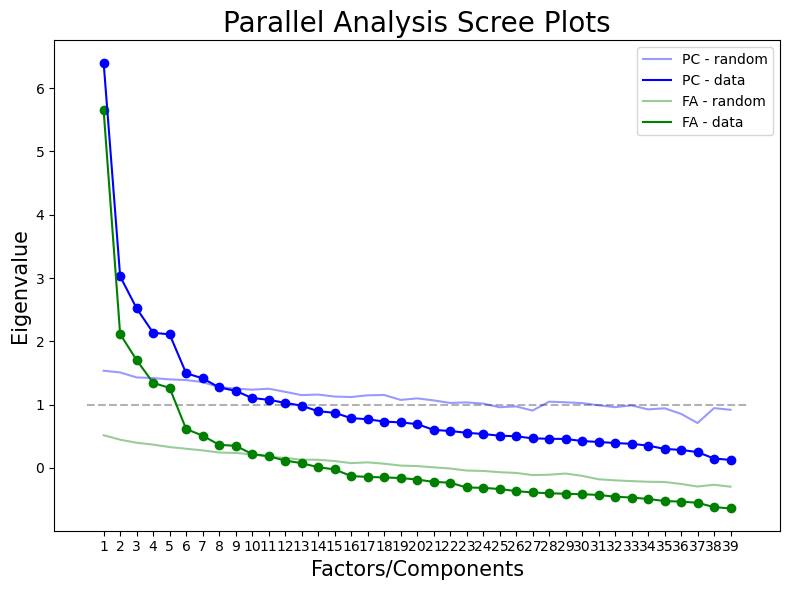

In [10]:
# Run factor analysis
fn_22 = factor_22.dropna()  # nans need to be dropped before calculating sphericity and Kaiser
chi_square_value, p_value = calculate_bartlett_sphericity(fn_22)  # p < .001
kmo_all, kmo_model = calculate_kmo(fn_22)  # kmo_model = .81
_HornParallelAnalysis(fn_22, K=10)  # run a "parallel analysis" per Horn's (1965) idea of possibilities for random data points to yield
# reasonably high eigen-values; based on the results of this analysis, keep the first eight components

fa_22 = FactorAnalyzer(n_factors=8, rotation='varimax', method='principal')
fa_22.fit(fn_22)
ev_22, vs_22 = fa_22.get_eigenvalues()
factor_cols = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8']
loadings_22 = pd.DataFrame(fa_22.loadings_, columns=factor_cols, index=factor_22.columns)
loadings_22.to_csv(os.path.join(os.getcwd(), '22_loadings.csv'))
